<a href="https://www.kaggle.com/code/francescoliveras/ps-s5-e11-eda-model-en-es?scriptVersionId=280420112" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Playground Series S5E11 - Loan Paid Back (ROC AUC)


## <p style="font-family:Consolas Mono; font-weight:normal; letter-spacing: 2px; color:#06D1C7; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #008F77">Library import</p>
<a id="library-import"></a>

In [1]:
import json
import os
import random
import time
import warnings
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from typing import List, Dict
import math

SEED = 42
ID_COL = "id"
TARGET_COL = "loan_paid_back"

def set_seed(seed: int = SEED) -> None:
    """Propagate a reproducible seed across common libraries."""
    random.seed(seed)
    np.random.seed(seed)
    try:
        import torch  # type: ignore
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    except ModuleNotFoundError:
        pass

set_seed()

DATA_DIR_CANDIDATES = [
    Path("/kaggle/input/playground-series-s5e11"),
    Path("playground-series-s5e11")
]

for candidate in DATA_DIR_CANDIDATES:
    if candidate.exists():
        DATA_DIR = candidate
        break
else:
    raise FileNotFoundError("Dataset directory not found. Update DATA_DIR_CANDIDATES if running locally.")

OUTPUT_DIR = Path("outputs")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)


## <p style="font-family:Consolas Mono; font-weight:normal; letter-spacing: 2px; color:#06D1C7; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #008F77">Constants</p>
<a id="constants"></a>

In [2]:
# Paths
KAGGLE_INPUT_PATH = Path("/kaggle/input/playground-series-s5e11")
LOCAL_INPUT_PATH = Path("playground-series-s5e11")

DATA_DIR = KAGGLE_INPUT_PATH if KAGGLE_INPUT_PATH.exists() else LOCAL_INPUT_PATH

TRAIN_FILENAME = "train.csv"
TEST_FILENAME = "test.csv"
SAMPLE_SUBMISSION_FILENAME = "sample_submission.csv"

TARGET = "accident_risk"
ID_COLUMN = "id"
PRIMARY_METRIC = "rmse"
SEED = 200
N_SPLITS = 5
PAIRPLOT_SAMPLE = 5000

# Palette reproduced from Plantilla.ipynb
yellow = "#F7C53E"
cyan_g = "#0CF7AF"
cyan_dark = "#11AB7C"
purple = "#D826F8"
purple_dark = "#9309AB"
purple_light = "#b683d6"
blue = "#0C97FA"
red = "#FA1D19"
orange = "#FA9F19"
green = "#0CFA58"
light_blue = "#01FADC"
soft_blue = "#81c9e6"
dark_blue = "#394be6"

PALETTE_2 = [cyan_g, purple]
PALETTE_3 = [yellow, cyan_g, purple]
PALETTE_4 = [yellow, orange, purple, light_blue]
PALETTE_5 = [purple_dark, purple_light, purple, blue, light_blue]
PALETTE_6 = [blue, red, orange, green, light_blue, purple]
PALETTE_7 = [purple_dark, purple_light, purple, blue, light_blue, dark_blue, soft_blue]
PALETTE_7_C = [purple_dark, blue, purple, light_blue, purple_light, soft_blue, dark_blue]

sns.set_style("whitegrid")
sns.set_palette(PALETTE_7)
plt.style.use({"figure.facecolor": "#f8fafc"})

pd.set_option("display.float_format", "{:.4f}".format)
warnings.filterwarnings("ignore")

## <p style="font-family:Consolas Mono; font-weight:normal; letter-spacing: 2px; color:#06D1C7; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #008F77">Data import</p>
<a id="data-agent"></a>

In [3]:
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")
sample_submission = pd.read_csv(DATA_DIR / "sample_submission.csv")

print(f"Forma de train: {train.shape}")
print(f"Forma de test: {test.shape}")
class_counts = train[TARGET_COL].value_counts(normalize=True)
print("Prevalencia del target:", class_counts.to_dict())


Forma de train: (593994, 13)
Forma de test: (254569, 12)
Prevalencia del target: {1.0: 0.7988195166954548, 0.0: 0.20118048330454516}


## <p style="font-family:Consolas Mono; font-weight:normal; letter-spacing: 2px; color:#06D1C7; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #008F77">Functions</p>
<a id="functions"></a>

Functions


In [4]:
def bilingual_print(en: str, es: str) -> None:
    print(f"EN> {en}")
    print(f"ES> {es}")

In [5]:
def plot_correlation_heatmap(df: pd.DataFrame, target: str) -> None:
    numeric_df = df.select_dtypes(include=["number"])
    corr = numeric_df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, mask=mask, cmap=PALETTE_2, annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Feature Correlation / Correlación de Variables")
    plt.tight_layout()
    plt.show()

In [6]:
def plot_pairgrid(df: pd.DataFrame, columns: List[str], sample_size: int = PAIRPLOT_SAMPLE) -> None:
    if len(columns) < 2:
        bilingual_print("Not enough numeric features for pairplot.", "No hay suficientes variables numéricas para pairplot.")
        return
    sample_df = df[columns].sample(min(len(df), sample_size), random_state=SEED)
    sns.pairplot(sample_df, diag_kind="kde", corner=True, plot_kws={"alpha": 0.5, "s": 20, "color": PALETTE_7[3]})
    plt.suptitle("Pairplot of Numeric Features", y=1.02)
    plt.show()

In [7]:
def feature_group_statistics(df: pd.DataFrame, group_col: str, target: str) -> pd.DataFrame:
    agg = df.groupby(group_col)[target].agg(["count", "mean", "median", "std"]).reset_index()
    agg = agg.sort_values("mean", ascending=False)
    return agg

In [8]:
def evaluate_models(models: Dict[str, object], X: pd.DataFrame, y: pd.Series, preprocessor: ColumnTransformer, n_splits: int = N_SPLITS) -> pd.DataFrame:
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    results = []
    for name, estimator in models.items():
        fold_metrics = []
        start = time.time()
        for train_idx, valid_idx in cv.split(X, y):
            pipeline = Pipeline([
                ("preprocessor", clone(preprocessor)),
                ("model", clone(estimator)),
            ])
            pipeline.fit(X.iloc[train_idx], y.iloc[train_idx])
            preds = pipeline.predict(X.iloc[valid_idx])
            rmse = mean_squared_error(y.iloc[valid_idx], preds, squared=False)
            mae = mean_absolute_error(y.iloc[valid_idx], preds)
            fold_metrics.append((rmse, mae))
        duration = time.time() - start
        rmses, maes = zip(*fold_metrics)
        results.append({
            "model": name,
            "rmse_mean": float(np.mean(rmses)),
            "rmse_std": float(np.std(rmses)),
            "mae_mean": float(np.mean(maes)),
            "fit_time_sec": duration,
        })
    leaderboard = pd.DataFrame(results).sort_values("rmse_mean").reset_index(drop=True)
    return leaderboard

In [9]:
def plot_numeric_distributions(df: pd.DataFrame, numeric_cols: List[str], target: str) -> None:
    if not numeric_cols:
        bilingual_print("No numeric features to profile.", "No hay variables numéricas para perfilar.")
        return

    n_cols = 2
    n_rows = math.ceil(len(numeric_cols) / n_cols)
    plt.figure(figsize=(16, 5 * n_rows))
    for idx, col in enumerate(numeric_cols, 1):
        ax = plt.subplot(n_rows, n_cols, idx)
        sns.scatterplot(data=df, x=col, y=target, color=PALETTE_7[idx % len(PALETTE_7)], alpha=0.6, ax=ax)
        # statsmodels is required by seaborn for lowess smoothing. Detect availability and fall back if missing.
        try:
            import statsmodels  # noqa: F401
            use_lowess = True
        except Exception:
            use_lowess = False
        try:
            sns.regplot(data=df, x=col, y=target, scatter=False, lowess=use_lowess, color=PALETTE_7_C[idx % len(PALETTE_7_C)], ax=ax)
        except Exception:
            # Final fallback: simple linear fit using numpy.polyfit if regplot fails
            valid = df[[col, target]].dropna()
            if len(valid) >= 2:
                xs = valid[col].astype(float)
                ys = valid[target].astype(float)
                coeffs = np.polyfit(xs, ys, deg=1)
                line_x = np.linspace(xs.min(), xs.max(), 100)
                line_y = np.polyval(coeffs, line_x)
                ax.plot(line_x, line_y, color=PALETTE_7_C[idx % len(PALETTE_7_C)])
        ax.set_title(f"{col} vs {target}")
    plt.tight_layout()
    plt.show()

In [10]:
def plot_categorical_summary(df: pd.DataFrame, categorical_cols: List[str], target: str) -> None:
    if not categorical_cols:
        bilingual_print("No categorical features to profile.", "No hay variables categóricas para perfilar.")
        return

    for col in categorical_cols:
        fig, axes = plt.subplots(1, 2, figsize=(18, 5))
        order = df[col].value_counts().index
        sns.countplot(data=df, x=col, order=order, palette=PALETTE_7, ax=axes[0])
        axes[0].set_title(f"{col} — counts")
        axes[0].tick_params(axis='x', rotation=30)
        sns.barplot(data=df, x=col, y=target, order=order, palette=PALETTE_7_C, ax=axes[1])
        axes[1].set_title(f"{col} vs {target} (mean)")
        axes[1].tick_params(axis='x', rotation=30)
        plt.tight_layout()
        plt.show()

In [11]:
def build_eda_summary(df: pd.DataFrame) -> pd.DataFrame:
    """Create a compact summary table with missingness and cardinality."""
    summary_rows = []
    for column in df.columns:
        series = df[column]
        non_null = series.dropna()
        summary_rows.append({
            "feature": column,
            "dtype": str(series.dtype),
            "missing_count": int(series.isna().sum()),
            "missing_pct": float(series.isna().mean() * 100.0),
            "nunique": int(series.nunique()),
            "sample_values": ", ".join(non_null.astype(str).head(3))
        })
    return pd.DataFrame(summary_rows)

eda_summary = build_eda_summary(train.drop(columns=[TARGET_COL]))
eda_summary_path = OUTPUT_DIR / "eda_summary.csv"
eda_summary.to_csv(eda_summary_path, index=False)
print(f"Resumen EDA guardado en {eda_summary_path}")
display(eda_summary.head(10))


Resumen EDA guardado en outputs/eda_summary.csv


,feature,dtype,missing_count,missing_pct,nunique,sample_values
0,id,int64,0,0.0000,593994,"0, 1, 2"
1,annual_income,float64,0,0.0000,119728,"29367.99, 22108.02, 49566.2"
2,debt_to_income_ratio,float64,0,0.0000,526,"0.084, 0.166, 0.097"
3,credit_score,int64,0,0.0000,399,"736, 636, 694"
4,loan_amount,float64,0,0.0000,111570,"2528.42, 4593.1, 17005.15"
5,interest_rate,float64,0,0.0000,1454,"13.67, 12.92, 9.76"
6,gender,object,0,0.0000,3,"Female, Male, Male"
7,marital_status,object,0,0.0000,4,"Single, Married, Single"
8,education_level,object,0,0.0000,5,"High School, Master's, High School"
9,employment_status,object,0,0.0000,5,"Self-employed, Employed, Employed"


## <p style="font-family:Consolas Mono; font-weight:normal; letter-spacing: 2px; color:#06D1C7; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #008F77">Data analysis</p>
<a id="analysis-agent"></a>

### Visualizaciones exploratorias

Inspecciones clave para entender la distribución del objetivo, las correlaciones numéricas y los patrones categóricos antes del modelado.


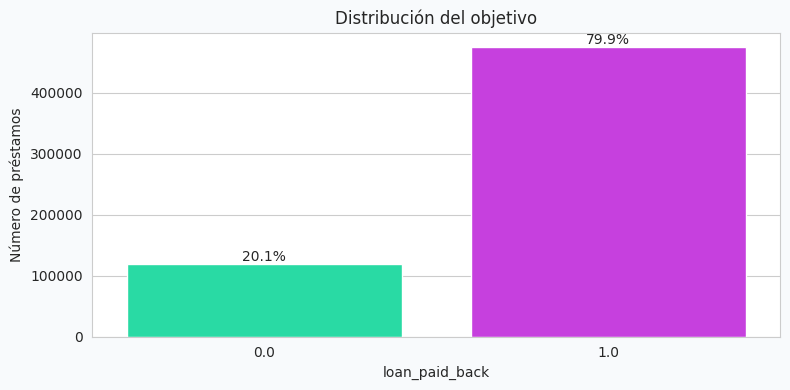

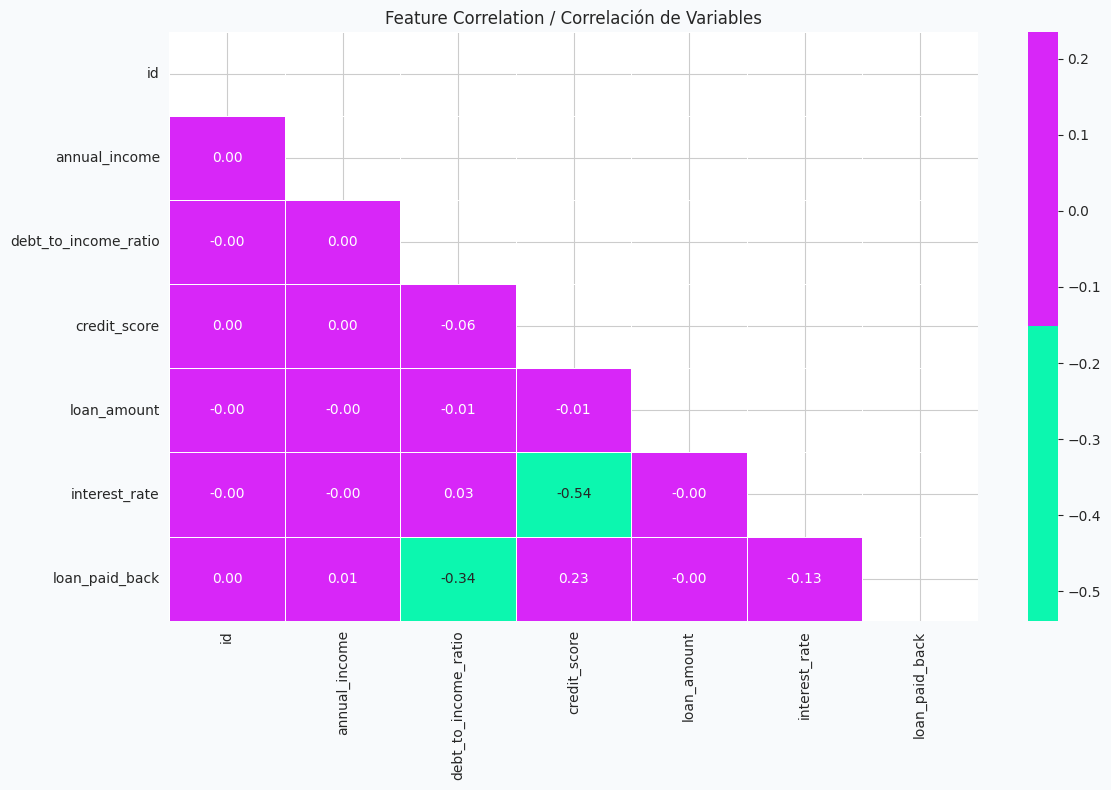

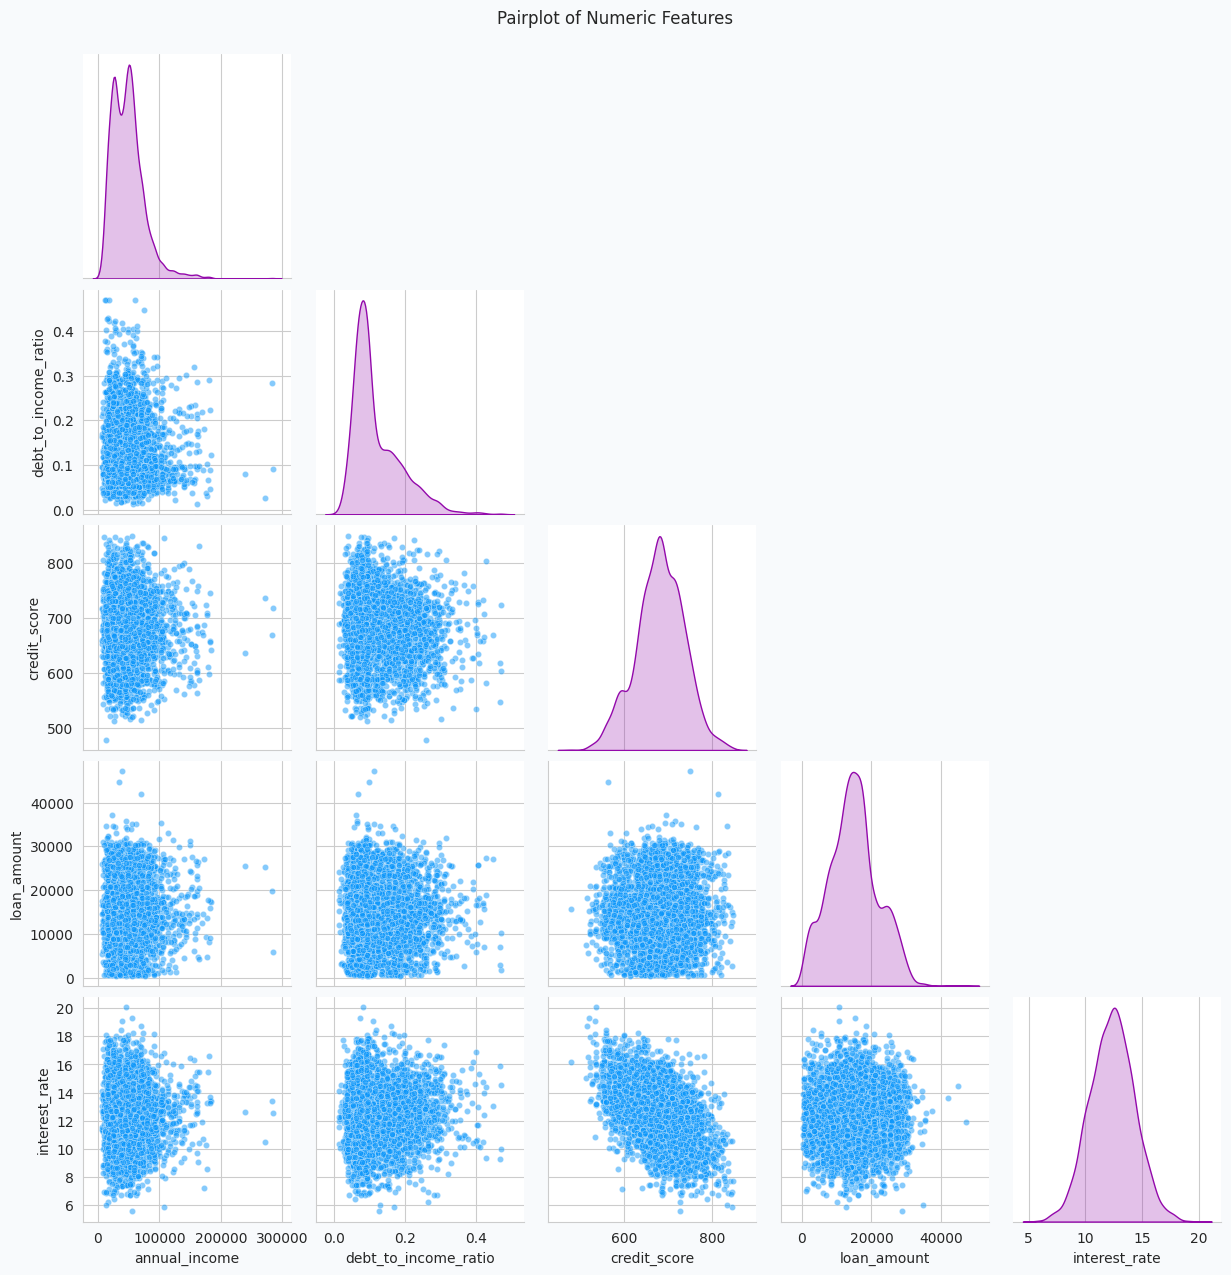

In [12]:
plot_sample = train.sample(
    n=min(PAIRPLOT_SAMPLE, len(train)),
    random_state=SEED,
)

numeric_cols = [
    col
    for col in train.select_dtypes(include=[np.number]).columns
    if col not in (ID_COL, TARGET_COL)
]

# Target distribution (annotated manually to avoid matplotlib.bar_label issues)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.countplot(data=train, x=TARGET_COL, palette=PALETTE_2, ax=ax)
ax.set_title('Distribución del objetivo')
ax.set_xlabel(TARGET_COL)
ax.set_ylabel('Número de préstamos')
total = len(train)
for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f"{height / total:.1%}", ha='center', va='bottom', fontsize=10)
plt.tight_layout()

# Correlation heatmap using helper function
plot_correlation_heatmap(train, TARGET_COL)

# Pairgrid for numeric features (may be heavy; sample controlled inside function)
plot_pairgrid(train, numeric_cols)


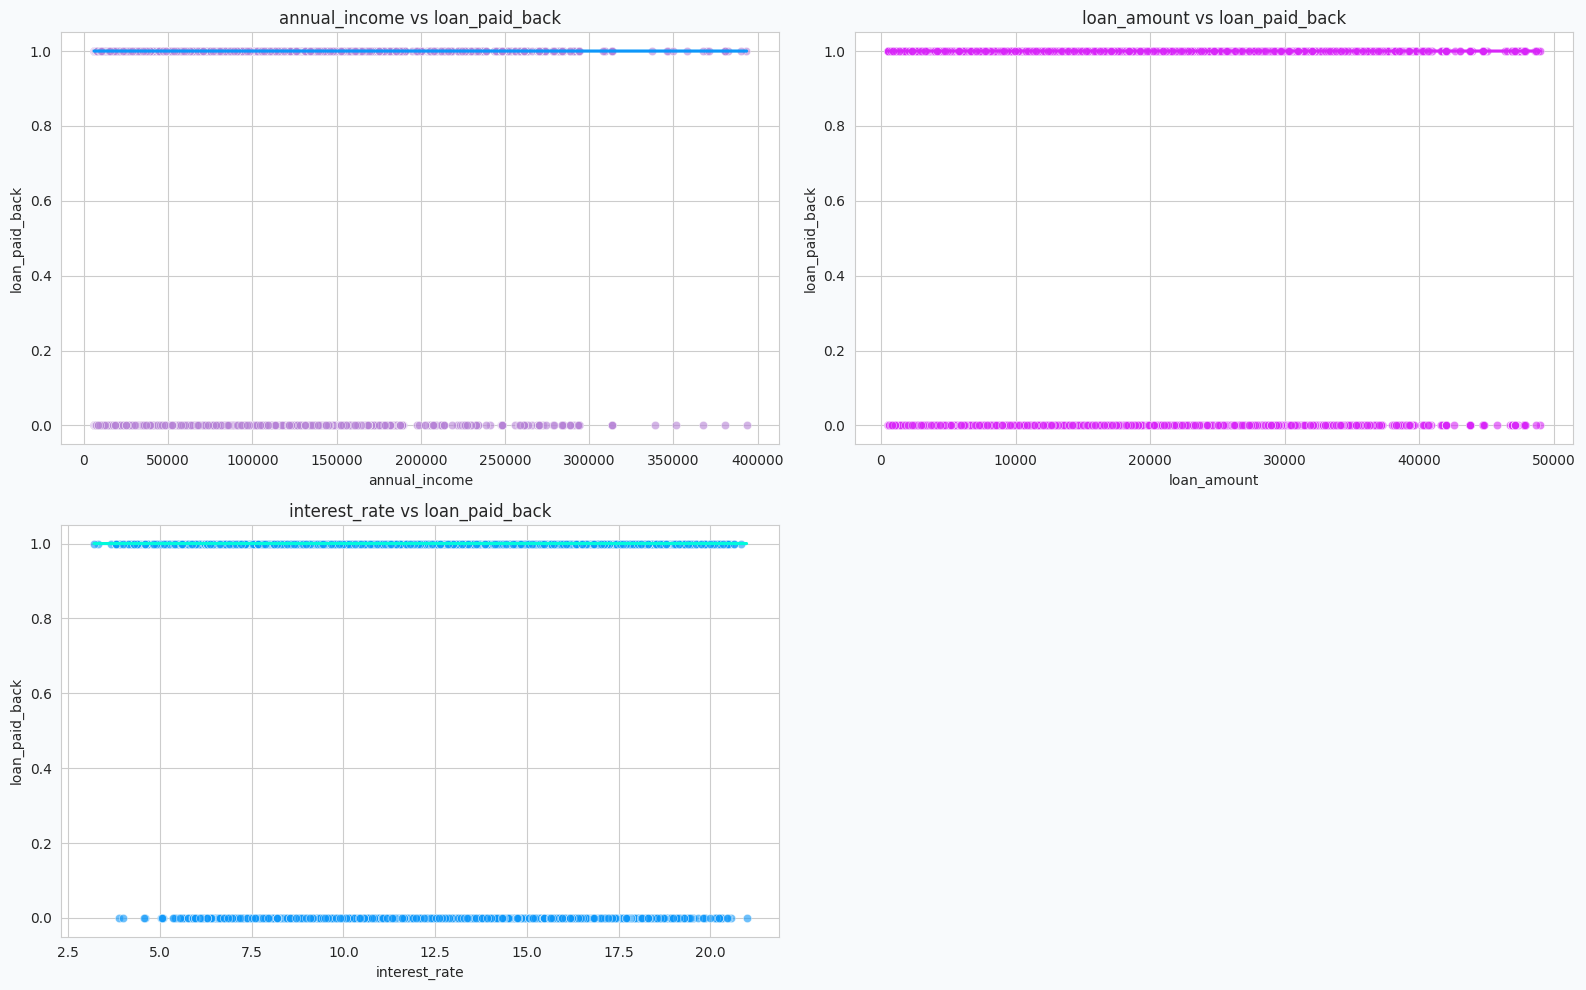

In [13]:
# Use reusable plotting helpers for scatter/box visuals
plot_numeric_distributions(train, ['annual_income', 'loan_amount', 'interest_rate'], TARGET_COL)


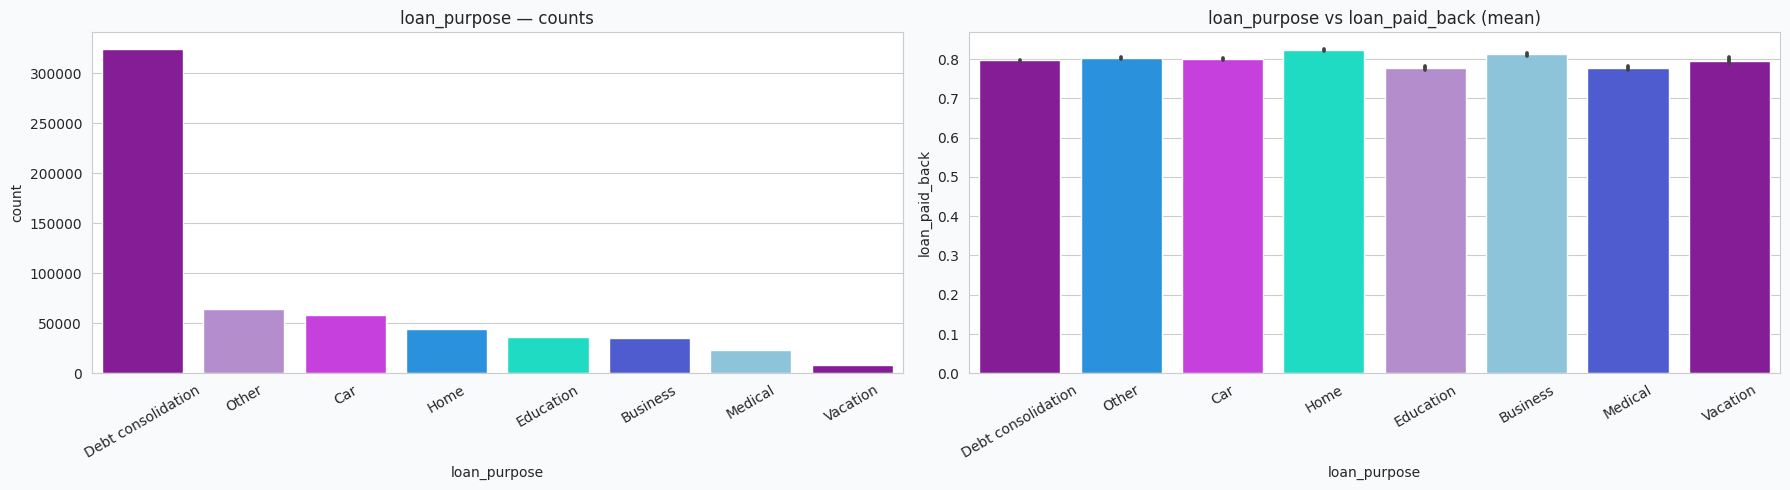

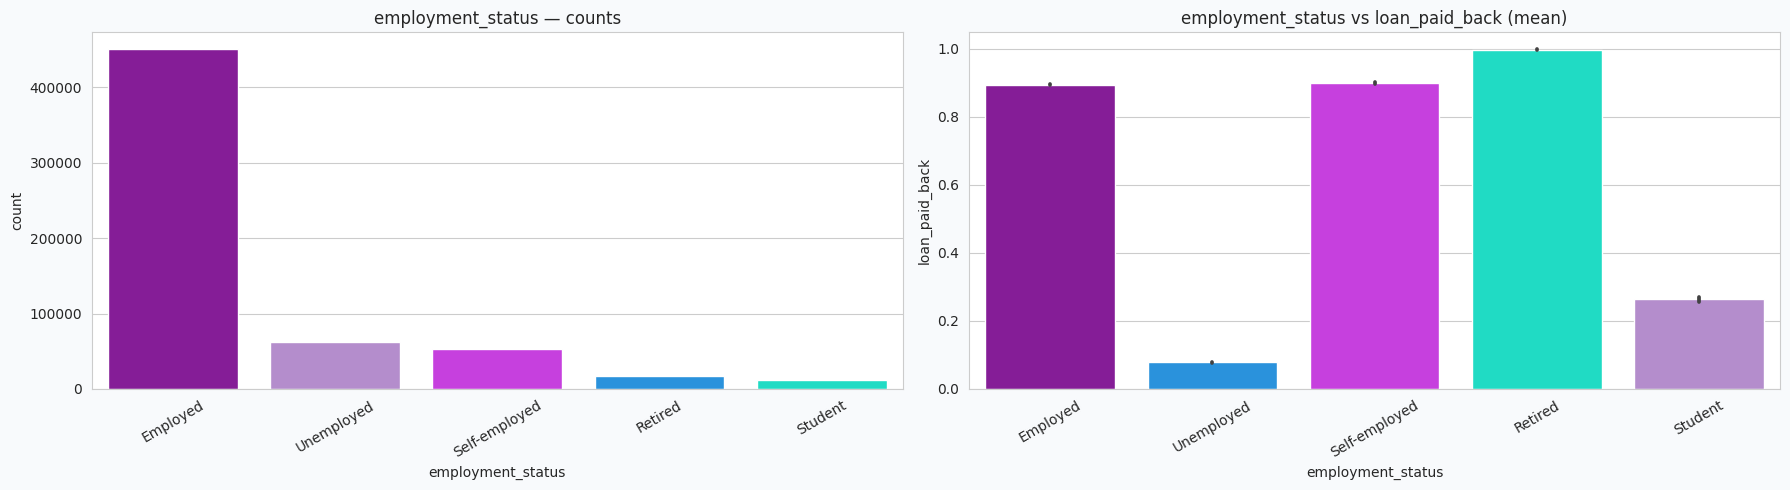

,loan_purpose,count,mean,median,std
4,Home,44118,0.8232,1.0000,0.3815
0,Business,35303,0.8131,1.0000,0.3898
6,Other,63874,0.8024,1.0000,0.3982
1,Car,58108,0.8006,1.0000,0.3995
2,Debt consolidation,324695,0.7969,1.0000,0.4023
7,Vacation,8449,0.7961,1.0000,0.4029
5,Medical,22806,0.7781,1.0000,0.4155
3,Education,36641,0.7771,1.0000,0.4162


,employment_status,count,mean,median,std
1,Retired,16453,0.9972,1.0000,0.0528
2,Self-employed,52480,0.8985,1.0000,0.3020
0,Employed,450645,0.8941,1.0000,0.3077
3,Student,11931,0.2635,0.0000,0.4406
4,Unemployed,62485,0.0776,0.0000,0.2676


In [14]:
# Use reusable categorical summary plotting for top categories
purpose_summary = feature_group_statistics(train, 'loan_purpose', TARGET_COL).head(8)
employment_summary = feature_group_statistics(train, 'employment_status', TARGET_COL)
plot_categorical_summary(train, ['loan_purpose', 'employment_status'], TARGET_COL)
display(purpose_summary)
display(employment_summary)


In [15]:
baseline_probability = float(train[TARGET_COL].mean())
baseline_submission = sample_submission.copy()
baseline_submission[TARGET_COL] = baseline_probability
baseline_path = Path("submission_baseline.csv")
baseline_submission.to_csv(baseline_path, index=False)
print(f"Probabilidad constante (baseline): {baseline_probability:.6f}")
print(f"Baseline guardada en {baseline_path}")


Probabilidad constante (baseline): 0.798820
Baseline guardada en submission_baseline.csv


## <p style="font-family:Consolas Mono; font-weight:normal; letter-spacing: 2px; color:#06D1C7; font-size:130%; text-align:left;padding: 0px; border-bottom: 3px solid #008F77">Model selection</p>
<a id="model-agent"></a>

In [16]:
feature_cols = [col for col in train.columns if col not in (TARGET_COL,)]
cat_cols = [col for col in feature_cols if train[col].dtype == "object"]
num_cols = [col for col in feature_cols if train[col].dtype != "object"]

print(f"Total de variables: {len(feature_cols)} | numÃ©ricas: {len(num_cols)} | categÃ³ricas: {len(cat_cols)}")

num_processor = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

cat_processor = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ]
)

preprocessor_template = ColumnTransformer(
    transformers=[
        ("num", num_processor, num_cols),
        ("cat", cat_processor, cat_cols)
    ]
)

model_params = {
    "objective": "binary",
    "learning_rate": 0.05,
    "n_estimators": 1200,
    "num_leaves": 63,
    "max_depth": -1,
    "min_child_samples": 120,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 0.2,
    "random_state": SEED,
    "n_jobs": -1,
    "verbosity": -1
}

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)


Total de variables: 12 | numÃ©ricas: 6 | categÃ³ricas: 6


In [17]:
X = train[feature_cols]
y = train[TARGET_COL]
test_features = test[feature_cols]

oof = np.zeros(train.shape[0], dtype=np.float32)
test_pred = np.zeros(test.shape[0], dtype=np.float32)
cv_rows = []
feature_importances = []
best_iterations = []

for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y), start=1):
    fold_start = time.time()
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_valid = X.iloc[valid_idx]
    y_valid = y.iloc[valid_idx]

    preprocessor = clone(preprocessor_template)
    X_train_proc = preprocessor.fit_transform(X_train)
    X_valid_proc = preprocessor.transform(X_valid)
    X_test_proc = preprocessor.transform(test_features)

    X_train_proc = X_train_proc.astype(np.float32)
    X_valid_proc = X_valid_proc.astype(np.float32)
    X_test_proc = X_test_proc.astype(np.float32)

    model = LGBMClassifier(**model_params)
    model.fit(
        X_train_proc,
        y_train,
        eval_set=[(X_valid_proc, y_valid)],
        eval_metric="auc",
        callbacks=[
            early_stopping(stopping_rounds=50, verbose=False),
            log_evaluation(period=100)
        ]
    )

    valid_pred = model.predict_proba(X_valid_proc)[:, 1]
    oof[valid_idx] = valid_pred
    fold_auc = roc_auc_score(y_valid, valid_pred)
    fold_duration = time.time() - fold_start

    print(f"Fold {fold} | AUC {fold_auc:.6f} | iteraciÃ³n Ã³ptima {model.best_iteration_} | duraciÃ³n {fold_duration:.1f}s")

    cv_rows.append({
        "fold": fold,
        "auc": float(fold_auc),
        "best_iteration": int(model.best_iteration_),
        "duration_seconds": float(fold_duration)
    })
    best_iterations.append(int(model.best_iteration_))
    test_pred += model.predict_proba(X_test_proc)[:, 1] / n_splits

    booster = model.booster_
    feature_names = preprocessor.get_feature_names_out()
    feature_importances.append(pd.DataFrame({
        "feature": feature_names,
        "importance_gain": booster.feature_importance(importance_type="gain"),
        "importance_split": booster.feature_importance(importance_type="split"),
        "fold": fold
    }))

overall_auc = roc_auc_score(y, oof)
print(f"ROC AUC OOF: {overall_auc:.6f}")


[100]	valid_0's auc: 0.920881	valid_0's binary_logloss: 0.246576
[200]	valid_0's auc: 0.922297	valid_0's binary_logloss: 0.24406
[300]	valid_0's auc: 0.922759	valid_0's binary_logloss: 0.243379
[400]	valid_0's auc: 0.923085	valid_0's binary_logloss: 0.24295
[500]	valid_0's auc: 0.923244	valid_0's binary_logloss: 0.242714
[600]	valid_0's auc: 0.923433	valid_0's binary_logloss: 0.242465
Fold 1 | AUC 0.923452 | iteraciÃ³n Ã³ptima 642 | duraciÃ³n 29.5s
[100]	valid_0's auc: 0.920011	valid_0's binary_logloss: 0.247562
[200]	valid_0's auc: 0.921574	valid_0's binary_logloss: 0.244824
[300]	valid_0's auc: 0.921839	valid_0's binary_logloss: 0.244361
[400]	valid_0's auc: 0.922083	valid_0's binary_logloss: 0.243974
[500]	valid_0's auc: 0.922376	valid_0's binary_logloss: 0.243567
[600]	valid_0's auc: 0.922462	valid_0's binary_logloss: 0.243459
Fold 2 | AUC 0.922469 | iteraciÃ³n Ã³ptima 555 | duraciÃ³n 26.2s
[100]	valid_0's auc: 0.919396	valid_0's binary_logloss: 0.24936
[200]	valid_0's auc: 0.92117

In [18]:
cv_summary = pd.DataFrame(cv_rows)
feature_importance_df = pd.concat(feature_importances, ignore_index=True)
feature_importance_summary = (
    feature_importance_df
    .groupby("feature", as_index=False)[["importance_gain", "importance_split"]]
    .mean()
    .sort_values("importance_gain", ascending=False)
)

oof_df = pd.DataFrame({
    ID_COL: train[ID_COL],
    "oof_prediction": oof
})

submission = sample_submission.copy()
submission[TARGET_COL] = test_pred

cv_path = OUTPUT_DIR / "cv.json"
cv_summary.to_json(cv_path, orient="records", indent=2)

oof_path = OUTPUT_DIR / "oof.csv"
oof_df.to_csv(oof_path, index=False)

feature_importance_path = OUTPUT_DIR / "feature_importance.csv"
feature_importance_summary.to_csv(feature_importance_path, index=False)

submission_path = Path("submission.csv")
submission.to_csv(submission_path, index=False)
submission.to_csv(OUTPUT_DIR / "submission.csv", index=False)

training_log = {
    "config": {
        "seed": SEED,
        "n_splits": n_splits,
        "data_dir": str(DATA_DIR),
        "output_dir": str(OUTPUT_DIR),
        "id_col": ID_COL,
        "target_col": TARGET_COL,
        "model_params": model_params,
        "early_stopping_rounds": 50
    },
    "averaged_best_iteration": float(np.mean(best_iterations)),
    "fold_auc_mean": float(cv_summary["auc"].mean()),
    "fold_auc_std": float(cv_summary["auc"].std()),
    "overall_auc": float(overall_auc),
    "best_iterations": best_iterations,
    "artifacts": {
        "submission": str(submission_path),
        "cv": str(cv_path),
        "oof": str(oof_path),
        "feature_importance": str(feature_importance_path),
        "eda_summary": str(eda_summary_path)
    },
    "timestamp": datetime.utcnow().isoformat() + "Z"
}

with open(OUTPUT_DIR / "training_log.json", "w", encoding="utf-8") as f:
    json.dump(training_log, f, indent=2)

print(f"Artefactos guardados en {OUTPUT_DIR}")
display(cv_summary)
display(feature_importance_summary.head(15))


Artefactos guardados en outputs


,fold,auc,best_iteration,duration_seconds
0,1,0.9235,642,29.5133
1,2,0.9225,555,26.2491
2,3,0.9220,595,27.8711
3,4,0.9212,538,25.7662
4,5,0.9210,689,30.9181


,feature,importance_gain,importance_split
1,cat__employment_status,1728422.7318,1169.8000
8,num__debt_to_income_ratio,537485.8575,8312.0000
7,num__credit_score,229688.2441,5173.8000
3,cat__grade_subgrade,64021.2729,1714.6000
11,num__loan_amount,33291.5124,4862.8000
6,num__annual_income,30240.8613,4695.4000
10,num__interest_rate,28756.2483,4501.8000
9,num__id,24411.9994,4241.4000
4,cat__loan_purpose,5966.3402,996.6000
0,cat__education_level,5085.6246,844.4000
